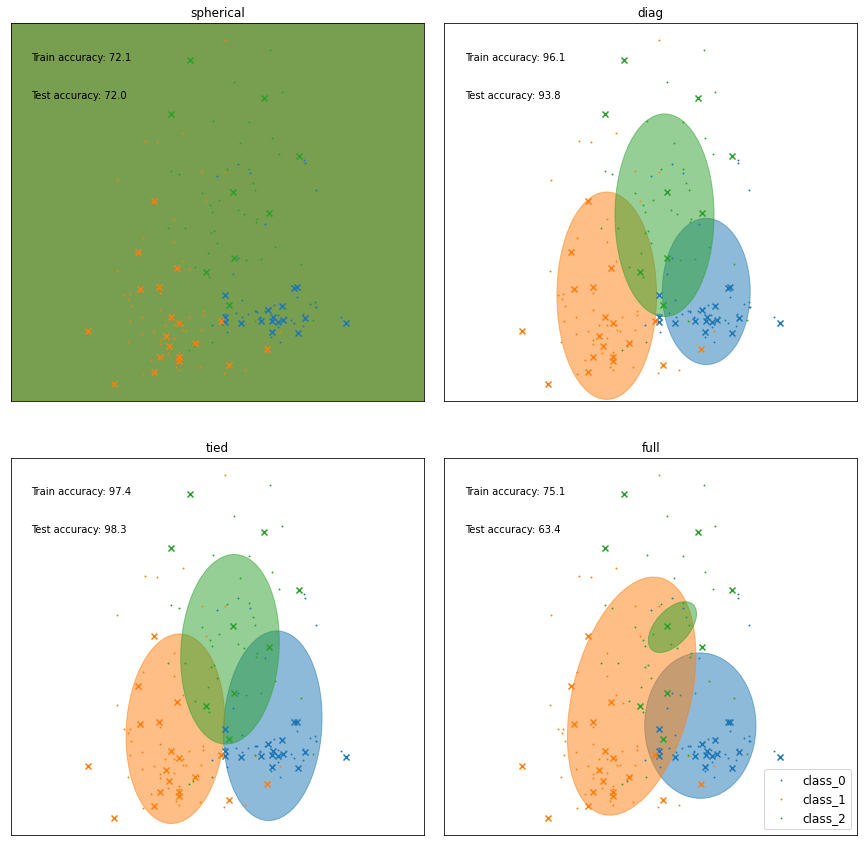

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np

from sklearn import datasets
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split, StratifiedKFold

K_FOLD_SPLITS = 4

wine_datasets = datasets.load_wine()

n_features = len(wine_datasets.feature_names)
n_classes = len(wine_datasets.target_names)

colors = ["C" + str(i) for i in range(n_classes)]

estimators = {
    cov_type: GaussianMixture(
        n_components=n_classes, covariance_type=cov_type, max_iter=20, random_state=0
    )
    for cov_type in ["spherical", "diag", "tied", "full"]
}

n_estimators = len(estimators)

plt.figure(figsize=(6*n_estimators//2, 12))
plt.subplots_adjust(
    bottom=0.01, top=0.95, hspace=0.15, wspace=0.05, left=0.01, right=0.99
)

def make_ellipses(gmm, ax):
    for n, color in enumerate(colors):
        if gmm.covariance_type == "full":
            covariances = gmm.covariances_[n][:2, :2]
        elif gmm.covariance_type == "tied":
            covariances = gmm.covariances_[:2, :2]
        elif gmm.covariance_type == "diag":
            covariances = np.diag(gmm.covariances_[n][:2])
        elif gmm.covariance_type == "spherical":
            covariances = np.eye(gmm.means_.shape[1])*gmm.covariances_[n] # means_ のサイズは (n_classes, n_features)
        v, w = np.linalg.eigh(covariances)
        u = w[0]/np.linalg.norm(w[0])
        angle = np.rad2deg(np.arctan2(u[1], u[0]))
        v = 2.0*np.sqrt(2.0)*np.sqrt(v)
        ell = mpl.patches.Ellipse(
            gmm.means_[n, :2], v[0], v[1], 180 + angle, color=color
        )
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)
        ax.set_aspect("equal", "datalim")

skf = StratifiedKFold(n_splits=K_FOLD_SPLITS,shuffle=True)

train_accuracy_array = np.zeros((4, K_FOLD_SPLITS))
test_accuracy_array = np.zeros((4, K_FOLD_SPLITS))

for times, (train_index, test_index) in enumerate(skf.split(wine_datasets.data, wine_datasets.target)):
    X_train, X_test = wine_datasets.data[train_index], wine_datasets.data[test_index]
    y_train, y_test = wine_datasets.target[train_index], wine_datasets.target[test_index]

    for index, (name, estimator) in enumerate(estimators.items()):
        estimator.means_init = np.array([X_train[y_train == i].mean(axis=0) for i in range(n_classes)])

        estimator.fit(X_train)

        y_train_pred = estimator.predict(X_train)
        train_accuracy = np.mean(y_train_pred.ravel() == y_train.ravel())*100
        train_accuracy_array[index][times] = train_accuracy

        y_test_pred = estimator.predict(X_test)
        test_accuracy = np.mean(y_test_pred.ravel() == y_test.ravel()) * 100
        test_accuracy_array[index][times] = test_accuracy

train_accuracy = np.mean(train_accuracy_array, axis=1)
test_accuracy = np.mean(test_accuracy_array, axis = 1)

X_train, X_test, y_train, y_test = train_test_split(wine_datasets.data, wine_datasets.target, test_size = 1/K_FOLD_SPLITS)

for index, (name, estimator) in enumerate(estimators.items()):
    estimator.means_init = np.array([X_train[y_train == i].mean(axis=0) for i in range(n_classes)])

    estimator.fit(X_train)

    h = plt.subplot(2, n_estimators//2, index + 1)
    make_ellipses(estimator, h)

    for n, color in enumerate(colors):
        data = wine_datasets.data[wine_datasets.target == n]
        plt.scatter(data[:, 0], data[:, 1], s=0.8, color=color, label=wine_datasets.target_names[n])

    for n, color in enumerate(colors):
        data = X_test[y_test == n]
        plt.scatter(data[:, 0], data[:, 1], marker="x", color=color)

    plt.text(0.05, 0.9, "Train accuracy: %.1f" % train_accuracy[index], transform=h.transAxes)
    plt.text(0.05, 0.8, "Test accuracy: %.1f" % test_accuracy[index], transform=h.transAxes)

    plt.xticks(())
    plt.yticks(())
    plt.title(name)

plt.legend(scatterpoints=1, loc="lower right", prop=dict(size=12))

plt.show()